# K均值聚类

In [9]:
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=4, suppress=True, threshold=16)
%matplotlib inline

## 机器学习实战

In [4]:
data = np.loadtxt('/mnt/data1/workspace/AI/data/机器学习/10.KMeans/testSet.txt')
data.shape

(80, 2)

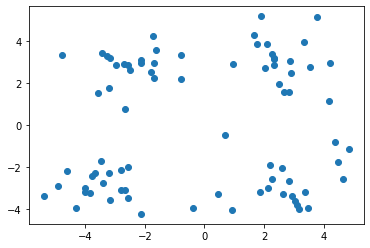

In [5]:
plt.scatter(data[:, 0], data[:, 1])

In [10]:
np.random.rand(3, 3)

Docstring:
rand(d0, d1, ..., dn)

Random values in a given shape.

.. note::
    This is a convenience function for users porting code from Matlab,
    and wraps `random_sample`. That function takes a
    tuple to specify the size of the output, which is consistent with
    other NumPy functions like `numpy.zeros` and `numpy.ones`.

Create an array of the given shape and populate it with
random samples from a uniform distribution
over ``[0, 1)``.

Parameters
----------
d0, d1, ..., dn : int, optional
    The dimensions of the returned array, must be non-negative.
    If no argument is given a single Python float is returned.

Returns
-------
out : ndarray, shape ``(d0, d1, ..., dn)``
    Random values.

See Also
--------
random

Examples
--------
>>> np.random.rand(3,2)
array([[ 0.14022471,  0.96360618],  #random
       [ 0.37601032,  0.25528411],  #random
       [ 0.49313049,  0.94909878]]) #random
Type:      builtin_function_or_method


In [34]:
class KMeans:
    def __init__(self, k):
        self.k = k  # 质心数目
    
    def init_(self, X):
        X_max = np.max(X, axis=0, keepdims=True)
        X_min = np.min(X, axis=0, keepdims=True)
        # 初始的类中心
        m0 = np.random.rand(self.k, X.shape[1]) * ((X_max - X_min) + X_min)
        # m0 = np.zeros((self.k, X.shape[1]))
        # for i in range(self.k):
        #     m_ = np.random.rand(X.shape[1]) * (X_max - X_min) + X_min
        #     m0[i] = m_
        return m0
      
    def fit(self, X):
        n_samples, n_features = X.shape
        # 保存聚类的结果, (所属类编号, 样本到所属类中心距离)
        cluster = np.zeros((n_samples, 2)) 
        # 初始化 中心
        m = self.init_(X)

        while True:
            cluster_last = cluster.copy()
            # 计算样本到各中心点距离, 指派到最近的点
            for i in range(n_samples):
                distance = np.sum(np.square(X[i] - m), axis=1)  # (k,)
                min_index = np.argmin(distance)
                # (所属类, 到类中心的平方距离)
                cluster[i] = (min_index, distance[min_index])
            
            # 计算新的中心
            # print(m)
            for l in range(self.k):
                m[l] = np.mean(X[cluster[:, 0] == l, :], axis=0)
            if np.all(cluster[:, 0] == cluster_last[:, 0]):
                break
        return m, cluster

In [35]:
clf = KMeans(4)
m, cluster = clf.fit(data)

In [36]:
cluster

array([[1.    , 0.1788],
       [0.    , 0.6802],
       [3.    , 1.0218],
       ...,
       [1.    , 0.5774],
       [0.    , 3.1678],
       [3.    , 1.6104]])

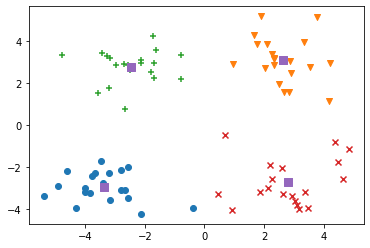

In [18]:
plt.scatter(data[cluster[:, 0]==0, 0], data[cluster[:, 0]== 0, 1], marker='o')
plt.scatter(data[cluster[:, 0]==1, 0], data[cluster[:, 0]== 1, 1], marker='v')
plt.scatter(data[cluster[:, 0]==2, 0], data[cluster[:, 0]== 2, 1], marker='+')
plt.scatter(data[cluster[:, 0]==3, 0], data[cluster[:, 0]== 3, 1], marker='x')
plt.scatter(m[:, 0], m[:, 1], marker='s', s=80)

In [19]:
SSE = np.sum(cluster[:, 1])
SSE

149.95430467642632

### 二分k-means算法
二分k-means算法是为了克服k-means算法收敛于局部最小值的问题,二分k-kmeans算法首先将所有点作为一个簇,然后将该簇一分为二.之后选择其中一个簇继续进行划分,选择哪一个簇进行划分取决于对其划分是否可以最大程度降低SSE值.上述基于SSE的划分过程不断重复,直到得到用户指定的簇数目为止

二分k-means的伪代码形式如下:
* 将所有点看成一个簇
* 当簇数目小于 k 时
* 对于每一个簇
    * 计算总误差
    * 在给定的簇上面进行 KMeans 聚类（k=2）
    * 计算将该簇一分为二之后的总误差
* 选择使得误差最小的那个簇进行划分操作

另一种做法是选择 SSE 最大的簇进行划分，直到簇数目达到用户指定的数目位置。

In [21]:
# 二分 K-Means 聚类算法
class BinMeans:
    def __init__(self, k):
        self.k = k
          
    def choose_best_cluster(self, X, cluster, m):
        # 选择最优的簇进行分类, 
        max_diff = 0
        # 当前所有类别
        m_index = np.unique(cluster[:, 0]).astype(int).tolist()
        cluster_m = []  # [((所有样本所属类别, 到其类中心的平方距离), 聚类中心)]
        for l in m_index:
            # 取同一类的数据
            data = X[cluster[:, 0]==l, :]
            # 聚类之前的SSE
            sse_before = np.sum(cluster[cluster[:, 0]==l, 1])  # 
            clf = KMeans(2)
            # 聚类中心, (所有样本所属类别, 到其类中心的平方距离)
            new_m, new_cluster = clf.fit(data)
            # 类的编号根据现有情况修改
            new_cluster[:, 0] += len(m)
            cluster_m.append((new_cluster, new_m))
            # 最大程度降低SSE的值
            diff = sse_before - np.sum(new_cluster[:, 1]) 
            if diff > max_diff:
                best_index = l
                max_diff = diff
        # 添加新的中心点 new_m
        m.extend(
            cluster_m[m_index.index(best_index)][1]
            )
        j = 0
        # 更新每个样本的类别编号和距离中心的距离
        for i in range(len(cluster)):
            # 需要更新的样本 
            if cluster[i, 0] == best_index:
                # 使用new_cluster的类别更新, 数据保持顺序  
                cluster[i] = cluster_m[m_index.index(best_index)][0][j]
                j += 1
        return cluster, m
            
            
    def fit(self, X):
        n_samples, n_features = X.shape
        # 所有样本分到一个簇中
        m_ = np.mean(X, axis=0)
        # 聚类中心坐标
        m = [m_]
        # (各样本的类, SSE)
        cluster = np.zeros((n_samples, 2))
        cluster[:, 1] = np.sum(np.square(X - m[0]), axis=1)
        
        while len(np.unique(cluster[:, 0])) < self.k:
            cluster, m = self.choose_best_cluster(X, cluster, m)
            # 对sse最大的簇进行 K-Means聚类(k=2)
        return np.array(m), cluster

In [22]:
clf = BinMeans(4)
m, cluster = clf.fit(data)

In [23]:
m

array([[-0.1036,  0.0543],
       [-0.2897, -2.8394],
       [ 0.0825,  2.948 ],
       [-3.3824, -2.9473],
       [ 2.8029, -2.7315],
       [ 2.6265,  3.1087],
       [-2.4615,  2.7874]])

In [24]:
SSE = np.sum(cluster[:, 1])
SSE

149.95430467642632

In [25]:
np.unique(cluster[:, 0])

array([3., 4., 5., 6.])

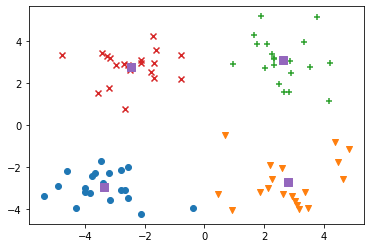

In [26]:
plt.scatter(data[cluster[:, 0]==3, 0], data[cluster[:, 0]== 3, 1], marker='o')
plt.scatter(data[cluster[:, 0]==4, 0], data[cluster[:, 0]== 4, 1], marker='v')
plt.scatter(data[cluster[:, 0]==5, 0], data[cluster[:, 0]== 5, 1], marker='+')
plt.scatter(data[cluster[:, 0]==6, 0], data[cluster[:, 0]== 6, 1], marker='x')
plt.scatter(m[3:, 0], m[3:, 1], marker='s', s=80)

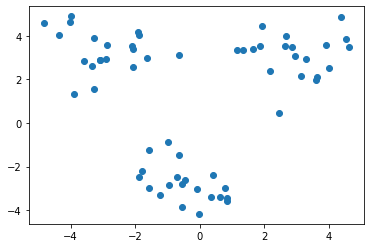

In [28]:
data = np.loadtxt('/mnt/data1/workspace/AI/data/机器学习/10.KMeans/testSet2.txt')
plt.scatter(data[:, 0], data[:, 1])

In [29]:
clf_k = KMeans(k=3)
m, cluster = clf_k.fit(data)

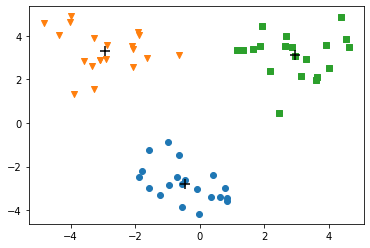

In [30]:

plt.scatter(data[cluster[:, 0]==0, 0], data[cluster[:, 0]== 0, 1], marker='o')
plt.scatter(data[cluster[:, 0]==1, 0], data[cluster[:, 0]== 1, 1], marker='v')
plt.scatter(data[cluster[:, 0]==2, 0], data[cluster[:, 0]== 2, 1], marker='s')
# plt.scatter(data[cluster[:, 0]==3, 0], data[cluster[:, 0]== 3, 1], marker='x')
plt.scatter(m[:, 0], m[:, 1], marker='+', s=100, c='k')

In [31]:
clf_k = BinMeans(k=3)
m, cluster = clf_k.fit(data)

In [32]:
np.unique(cluster[:, 0])

array([2., 3., 4.])

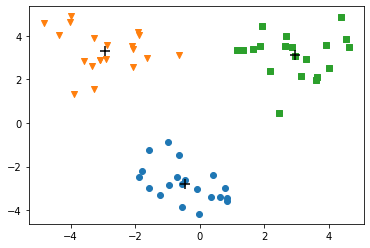

In [33]:
plt.scatter(data[cluster[:, 0]==2, 0], data[cluster[:, 0]== 2, 1], marker='o')
plt.scatter(data[cluster[:, 0]==3, 0], data[cluster[:, 0]== 3, 1], marker='v')
plt.scatter(data[cluster[:, 0]==4, 0], data[cluster[:, 0]== 4, 1], marker='s')
# plt.scatter(data[cluster[:, 0]==3, 0], data[cluster[:, 0]== 3, 1], marker='x')
plt.scatter(m[2:, 0], m[2:, 1], marker='+', s=100, c='k')

## sklearn  KMeans

```
Signature:
make_blobs(
    n_samples=100,
    n_features=2,
    centers=None,
    cluster_std=1.0,
    center_box=(-10.0, 10.0),
    shuffle=True,
    random_state=None,
)
Docstring:
Generate isotropic Gaussian blobs for clustering.

Read more in the :ref:`User Guide <sample_generators>`.
```

In [38]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

blobs, classes = make_blobs(500, centers=3)

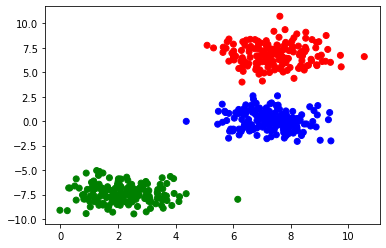

In [39]:
color_map = np.array(['r', 'g', 'b']) 
plt.scatter(blobs[:, 0], blobs[:, 1], color=color_map[classes])

```
class sklearn.cluster.KMeans(n_clusters=8, init=’k-means++’, n_init=10,
                            max_iter=300, tol=0.0001, precompute_distances=’auto’,
                            verbose=0, random_state=None, copy_x=True, n_jobs=None, algorithm=’auto’)
```


In [47]:
KMeans?

Init signature:
KMeans(
    n_clusters=8,
    *,
    init='k-means++',
    n_init=10,
    max_iter=300,
    tol=0.0001,
    precompute_distances='deprecated',
    verbose=0,
    random_state=None,
    copy_x=True,
    n_jobs='deprecated',
    algorithm='auto',
)
Docstring:     
K-Means clustering.

Read more in the :ref:`User Guide <k_means>`.

Parameters
----------

n_clusters : int, default=8
    The number of clusters to form as well as the number of
    centroids to generate.

init : {'k-means++', 'random', ndarray, callable}, default='k-means++'
    Method for initialization:

    'k-means++' : selects initial cluster centers for k-mean
    clustering in a smart way to speed up convergence. See section
    Notes in k_init for more details.

    'random': choose `n_clusters` observations (rows) at random from data
    for the initial centroids.

    If an ndarray is passed, it should be of shape (n_clusters, n_features)
    and gives the initial centers.

    If a callable is passe

In [40]:
# 假设已知有3个中心
kmean = KMeans(n_clusters=3)
kmean.fit(blobs)

KMeans(n_clusters=3)

In [41]:
classes

array([0, 0, 1, ..., 0, 2, 0])

In [42]:
# 每个样本点的预期标签, 由于 KMeans 不知道类别是什么, 与classes会不一致
kmean.labels_

array([0, 0, 1, ..., 0, 2, 0], dtype=int32)

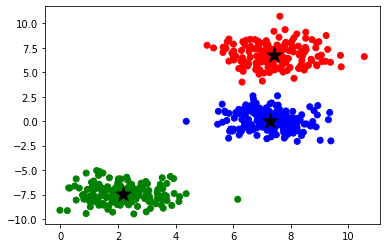

In [43]:
color_map = np.array(['r', 'g', 'b']) 
plt.scatter(blobs[:, 0], blobs[:, 1], color=color_map[classes])
# cluster 中心点坐标
plt.scatter(kmean.cluster_centers_[:, 0], kmean.cluster_centers_[:, 1], marker='*', s=250, color='k')

In [44]:
kmean.cluster_centers_  # b, r, g - > 2, 0, 1

array([[ 7.4263,  6.8031],
       [ 2.1789, -7.4032],
       [ 7.2774,  0.0582]])

In [45]:
kmean.predict([[5, -1], [-8, 3], [5, 5]])

array([2, 1, 0], dtype=int32)

In [46]:
# 输出每个点到形心的距离
kmean.transform(blobs[:5])

array([[ 1.427 , 14.8061,  6.9602],
       [ 1.9079, 15.2491,  6.3701],
       [14.4103,  0.8459,  8.2225],
       [ 2.1068, 15.2326,  6.3212],
       [ 1.8034, 13.6173,  4.9903]])

### 评估聚类的正确性
---
参考： [2.3.10. 聚类性能度量](https://github.com/apachecn/sklearn-doc-zh/blob/master/docs/0.21.3/22.md#2310-%E8%81%9A%E7%B1%BB%E6%80%A7%E8%83%BD%E5%BA%A6%E9%87%8F)


#### Silhouette 系数

In [19]:
blobs, classes = make_blobs(500, centers=3)
kmean = KMeans(n_clusters=3)
kmean.fit(blobs)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

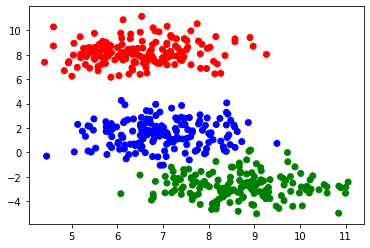

In [20]:
color_map = np.array(['r', 'g', 'b']) 
plt.scatter(blobs[:, 0], blobs[:, 1], color=color_map[classes])

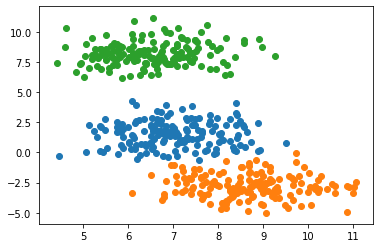

In [21]:
cluster_labels = kmean.labels_
plt.scatter(blobs[cluster_labels==2][:, 0], blobs[cluster_labels==2][:, 1])
plt.scatter(blobs[cluster_labels==1][:, 0], blobs[cluster_labels==1][:, 1])
plt.scatter(blobs[cluster_labels==0][:, 0], blobs[cluster_labels==0][:, 1])

首先，我们查看**轮廓**（Silhouette）距离。轮廓距离是簇内不相似性、最近的簇间不相似性、以及这两个值最大值的比值。它可以看做簇间分离程度的度量。
评估它的相似性
$$s_i = \frac {b_i - a_i}{max(a_i, b_i)}$$
$s_i$是观测样本$i$的**轮廓系数**(Silhouette Coefficient), 

$a_i$是i和同类的所有观测值之间的平均距离, $a_i$越小，说明样本i越应该被聚类到该簇,将$a_i$ 称为样本i的簇内不相似度;

 而$b_i$是i和不同类的所有观测的平均距离的最小值, 称为样本i的最近的簇间不相似性, $b_i$越大说明样本i越不属于其他簇
 

判断：
- si接近1，则说明样本i聚类合理；

- si接近-1，则说明样本i更应该分类到另外的簇；

- 若si 近似为0，则说明样本i在两个簇的边界上。

In [48]:
from sklearn import metrics
silhouette_samples = metrics.silhouette_samples(blobs, kmean.labels_)
silhouette_samples

array([0.7369, 0.6526, 0.8293, ..., 0.7515, 0.6354, 0.7736])

In [49]:
np.min(silhouette_samples)

0.22990115232886704

In [50]:
np.column_stack((classes[:5], silhouette_samples[:5]))

array([[0.    , 0.7369],
       [0.    , 0.6526],
       [1.    , 0.8293],
       [0.    , 0.6242],
       [0.    , 0.5829]])

(array([  1.,   1.,   3.,   1.,   6.,  14.,  40.,  80., 181., 173.]),
 array([0.2299, 0.2941, 0.3583, 0.4225, 0.4867, 0.5509, 0.6151, 0.6792,
        0.7434, 0.8076, 0.8718]),
 <a list of 10 Patch objects>)

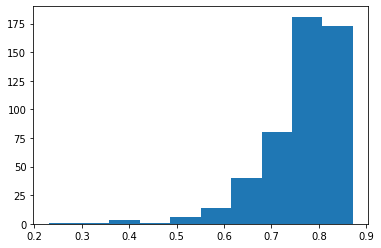

In [51]:
# 数据点到形心的距离分布
plt.hist(silhouette_samples)
# 通常接近 1 的系数越高，分数就越高

In [52]:
# 轮廓系数的均值通常用于描述整个模型的拟合度
silhouette_samples.mean()

0.7655789750438704

In [56]:
# 直接获取 轮廓系数的均值
metrics.silhouette_score(blobs, kmean.labels_)

0.7655789750438704

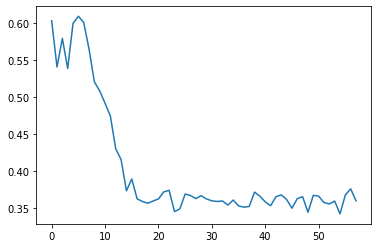

In [57]:
blobs, classes = make_blobs(500, centers=10)
sillhouette_avgs = []
for k in range(2, 60):
    kmean = KMeans(n_clusters=k).fit(blobs)
    sillhouette_avgs.append(metrics.silhouette_score(blobs, kmean.labels_))
plt.plot(sillhouette_avgs)

轮廓均值随着形心数量的变化情况. 最优的数量和实际的数量不一致, 这就是聚类的实际情况，十分普遍，我们不能获得正确的簇数量，我们只能估计簇数量的近似值

#### 准确度

In [59]:
# 各类别的准确度
for i in range(3):
    print((classes == labels)[classes==i].astype(int).mean())

0.0
0.0
0.0


In [65]:
blobs, classes = make_blobs(500, centers=3)
kmean = KMeans(n_clusters=3)
kmean.fit(blobs)

KMeans(n_clusters=3)

####  基于互信息(mutual information)的得分
在已知 真实簇的标签分配 labels_true 和我们的聚类算法基于相同样本所得到的 labels_pred， 互信息 是测量两个标签分配的 一致性(agreement)，忽略排列(permutations)。

$$I(X;Y)=\sum_x\sum_y p(x,y) log \frac{p(x,y)}{p(x)p(y)}$$
归一化的互信息(Normalized Mutual Information, NMI)
$$NMI(X;Y) = 2\frac {I(X;Y)}{H(X)+H(Y)}$$
分数靠近 0，就说明标签的分配可能不是按照相似过程生成的。但是分数靠近 1，就说明两个标签有很强的一致性。

In [66]:
metrics.adjusted_mutual_info_score(classes, kmean.labels_)

1.0

In [67]:
metrics.normalized_mutual_info_score(classes, kmean.labels_)

1.0

#### 惯性（inertia）度量. 

惯性是每个数据点和它所分配的簇的平方差之和

Sum of squared distances of samples to their closest cluster center.

In [69]:
kmean.inertia_

949.3313370692005

#### 调整后的兰德指数
在已知真实簇标签分配(the ground truth class assignment) labels_true 和我们的聚类算法基于相同样本所得到的 labels_pred，调整后的兰德指数(adjusted Rand index) 是一个函数，用于测量两个簇标签分配的值的 相似度 ，忽略排列(permutations)和 with chance normalization:

如果 C 是一个真实簇的标签分配， K 是簇的个数，我们定义 a 和 b 如:

- a, 在 C 中的相同集合的与 K 中的相同集合中的元素对数
- b, 在 C 中的不同集合与 K 中的不同集合中的元素对数

原始（未排序）的 Rand index 则由下式给出:

$$\text{RI} = \frac{a + b}{C_2^{n_{samples}}}$$

其中 $C_2^{n_{samples}}$ 是数据集中可能的数据对(pairs)的总数（不排序）。

然而，$RI$ 得分不能保证 随机标签分配(random label assignments)会获得接近零的值（特别是如果簇的数量与样本数量有着相同的规模排序）。

为了抵消这种影响，我们可以通过定义 adjusted Rand index 来低估(discount)随机标签的预期 $RI E[\text{RI}]$ ,如下所示:

$$\text{ARI} = \frac{\text{RI} - E[\text{RI}]}{\max(\text{RI}) - E[\text{RI}]}$$

In [70]:
metrics.adjusted_rand_score(classes, kmean.labels_)


1.0

#### 同质性，完整性和 V-measure
已知真实簇标签分配，可以使用 条件熵(conditional entropy)分析来定义一些直观的度量（intuitive metric）。

特别是 Rosenberg 和 Hirschberg (2007) 为任何簇分配定义了以下两个理想的目标:

- 同质性(homogeneity): 每个簇只包含一个类的成员
- 完整性(completeness): 给定类的所有成员都分配给同一个簇。

两者均在 1.0 以下 和 0.0 以上（越高越好）


In [71]:
metrics.homogeneity_score(classes, kmean.labels_)

1.0

In [72]:
metrics.completeness_score(classes, kmean.labels_)

1.0

称为 V-measure 的调和平均数(harmonic mean)由以下函数计算 v_measure_score:

该函数公式如下:

$$v = \frac{(1 + \beta) \times \text{homogeneity} \times \text{completeness}}{(\beta \times \text{homogeneity} + \text{completeness})}$$

beta默认值为1.0，但如果beta值小于1，则为:

In [73]:
metrics.v_measure_score(kmean.labels_, classes, beta=0.6)

1.0

In [74]:
# 更大的beta权重将提高同质性，当使用大于1的beta值时:
metrics.v_measure_score(kmean.labels_, classes, beta=1.6)

1.0

注意：

- v_measure_score 是 对称的: 它可以用于评估同一数据集上两个 无相关标签分配(independent assignments)的 一致性。
- completeness_score 和 homogeneity_score 却不适用于上述情况: 两者间存在下述约束:

  homogeneity_score(a, b) == completeness_score(b, a)

### k-means 聚类手写数字
---

In [75]:
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale

In [76]:
digits = load_digits()
data = scale(digits.data)  # z = (x-u) / s  归一化的data
digits.images[0], digits.target[0]

(array([[ 0.,  0.,  5., ...,  1.,  0.,  0.],
        [ 0.,  0., 13., ..., 15.,  5.,  0.],
        [ 0.,  3., 15., ..., 11.,  8.,  0.],
        ...,
        [ 0.,  4., 11., ..., 12.,  7.,  0.],
        [ 0.,  2., 14., ..., 12.,  0.,  0.],
        [ 0.,  0.,  6., ...,  0.,  0.,  0.]]),
 0)

In [77]:
# 打印图片信息
def print_digits(images, y, max_n=10):
    fig = plt.figure(figsize=(12, 12))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1,
                       hspace=0.05, wspace=0.005)
    i = 0
    while i < max_n and i < images.shape[0]:
        p = fig.add_subplot(20, 20, i+1, xticks=[], yticks=[])
        p.imshow(images[i], cmap=plt.cm.bone)
        p.text(0, 14, str(y[i]))
        i += 1

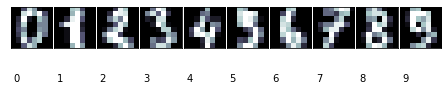

In [78]:
# 前10张图片
print_digits(digits.images, digits.target)

In [79]:
from sklearn.model_selection import train_test_split

# 训练集 测试集 
X_train, X_test, y_train, y_test, images_train, images_test = train_test_split(
    data, digits.target, digits.images, test_size=0.3, random_state=0)

In [80]:
n_digits = len(np.unique(y_train))
labels = y_train
n_digits

10

In [81]:
from sklearn.cluster import KMeans

clf = KMeans(init='k-means++', n_clusters=10, random_state=42)
clf.fit(X_train)

KMeans(n_clusters=10, random_state=42)

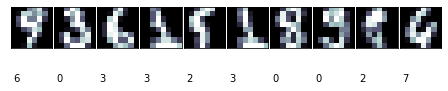

In [82]:
# 图像 预测分类
print_digits(images_train, clf.labels_, max_n=10)
# 预测的类编号与实际图片的数值无关, 是clf自身的分类

In [83]:
y_pred = clf.predict(X_test)

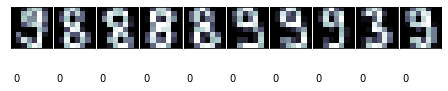

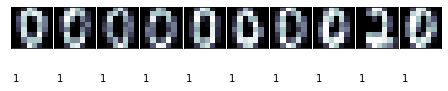

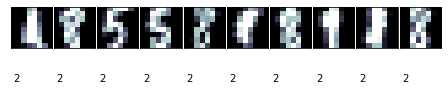

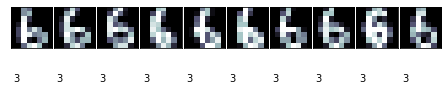

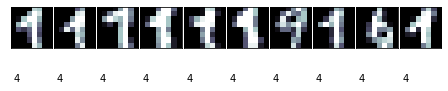

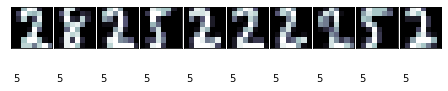

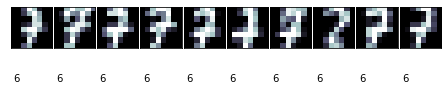

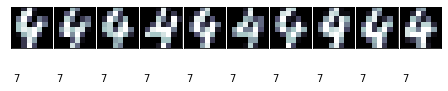

<Figure size 864x864 with 0 Axes>

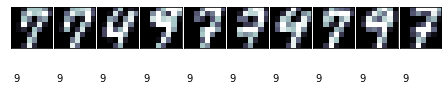

In [84]:
# 显示每个簇的10个图像
def print_cluster(images, y_pred, cluster_number):
    images = images[y_pred == cluster_number]
    y_pred = y_pred[y_pred == cluster_number]
    print_digits(images, y_pred, max_n=10)
    
for i in range(10):
    print_cluster(images_test, y_pred, i)

可以看到有些簇非常清晰, 如簇2对应数字0, 簇7对应数字6;有些簇不是那么清楚, 如簇6中有9、8和3

---
#### 评估
我们如何评估我们的表现？精确率和所有这些东西都不起作用，因为我们没有可比较的目标类。为了评估，我们需要知道“真正的”簇，无论这意味着什么。我们可以假设，对于我们的示例，每个簇包括特定数字的每个绘图，并且仅包括该数字。知道这一点，我们可以计算我们的簇分布和预期之间的调整**兰德系数**。兰德系数是一个类似的准确率量度，但它考虑到两个分布中的类可以有不同名称的事实。也就是说，如果我们更改类名，索引不会改变。调整兰德系数试图消除偶然发生的结果的巧合。当两个集合中具有完全相同的簇时，兰德系数等于 1，而当没有簇共享数据点时，它等于零。

In [85]:
from sklearn import metrics
# adjusted rand socre
metrics.adjusted_rand_score(y_test, y_pred)

0.417177093265168

In [86]:
# 混淆矩阵
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
# 数字0全部分类到了簇2, 完全一致
confusion_matrix[0]

array([ 0, 45,  0,  0,  0,  0,  0,  0,  0,  0])

In [87]:
# 数字9 5个分到簇0, 50个在簇6, 2个簇8
confusion_matrix[-1]

array([50,  0,  1,  0,  2,  0,  2,  0,  0,  2])

### 使用 KMeans 聚类来量化图像
---

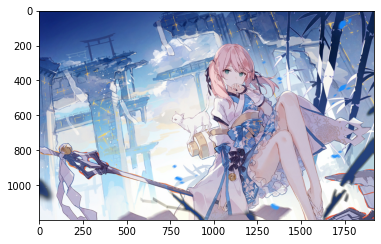

In [88]:
img = plt.imread('/home/ulysses/Pictures/111.jpg')
plt.imshow(img)

In [89]:
img.shape

(1200, 1920, 3)

为了实际量化图像，我们需要将其转换为二维数组，长为1080x1920，宽为 RGB 值. 

思考它的更好的方法，是拥有一堆三维空间中的数据点，并且对点进行聚类来降低图像中的不同颜色的数量 -- 这是一个简单的量化方式。

In [90]:
x, y, z = img.shape
long_img = img.reshape(x*y, z)
long_img.shape

(2304000, 3)

(array([  3367.,   9460.,  21651., ..., 260178., 293142., 457438.]),
 array([  0. ,   5.1,  10.2, ..., 244.8, 249.9, 255. ]),
 <a list of 50 Patch objects>)

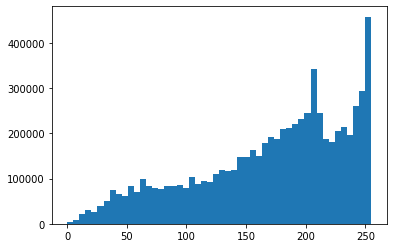

In [93]:
plt.hist(long_img.ravel(), bins=50)

In [98]:
long_img = long_img / 255.

In [99]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5)  # 5中颜色
kmeans.fit(long_img)

KMeans(n_clusters=5)

In [100]:
centers = kmeans.cluster_centers_ 
centers

array([[0.5296, 0.5779, 0.7076],
       [0.9283, 0.9424, 0.9491],
       [0.285 , 0.3934, 0.6047],
       [0.7442, 0.7492, 0.8215],
       [0.1377, 0.2193, 0.4388]])

In [101]:
labels = kmeans.labels_
labels[:5]

array([4, 4, 4, 4, 4], dtype=int32)

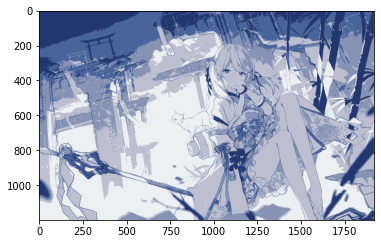

In [102]:
plt.imshow(centers[labels].reshape(x, y, z))

### MiniBatchKMeans 小批量KMeans聚类
---
MiniBatchKMeans 是 KMeans 算法的一个变种，它使用小批量(mini-batches)来减少计算时间，而这多个批次仍然尝试优化相同的目标函数。小批量是输入数据的子集，在每次训练迭代中随机抽样。这些小批量大大减少了收敛到局部解所需的计算量。 与其他降低 k-means 收敛时间的算法不同，小批量 k-means 产生的结果通常只比标准算法略差。

该算法在两个步骤之间进行迭代，类似于 vanilla k-means 。在第一步， b 样本是从数据集中随机抽取的，形成一个小批量。然后将它们分配到最近的质心。 在第二步，质心被更新。与 k-means 不同, 该变种算法是基于每个样本(per-sample)。对于小批量中的每个样本，通过取样本的流平均值(streaming average)和分配给该质心的所有先前样本来更新分配的质心。 这具有随时间降低质心的变化率（rate of change）的效果。执行这些步骤直到达到收敛或达到预定次数的迭代。

MiniBatchKMeans 收敛速度比 KMeans快 ，但是结果的质量会降低

In [103]:
from sklearn.datasets import load_iris
from sklearn.preprocessing import scale
from sklearn.cluster import MiniBatchKMeans

iris = load_iris()
X, y = iris.data, iris.target

X_std = scale(X)

In [104]:
#batch_size控制每批中随机选择的观测数。 批量越大，训练过程的计算成本就越高。
clf = MiniBatchKMeans(n_clusters=3, random_state=0, batch_size=100)
clf.fit(X_std)

MiniBatchKMeans(n_clusters=3, random_state=0)

In [105]:
clf.labels_

array([1, 1, 1, ..., 2, 2, 0], dtype=int32)

### MiniBatchKMeans和KMeans的对比


In [106]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans, MiniBatchKMeans

blobs, labels = make_blobs(int(1e6), 3)
kmeans = KMeans(n_clusters=3)
minibatch = MiniBatchKMeans(n_clusters=3)

In [107]:
# 对比运行时间
%time kmeans.fit(blobs)

CPU times: user 9.79 s, sys: 1.02 s, total: 10.8 s
Wall time: 3.03 s


KMeans(n_clusters=3)

In [108]:
%time minibatch.fit(blobs)

CPU times: user 2.83 s, sys: 184 ms, total: 3.02 s
Wall time: 2.1 s


MiniBatchKMeans(n_clusters=3)

In [109]:
# 类中心
kmeans.cluster_centers_

array([[ 4.6125, -0.915 ,  5.6674],
       [ 3.3082,  7.8135,  0.7037],
       [ 3.8656, -5.6257,  9.8955]])

In [110]:
minibatch.cluster_centers_

array([[ 4.5517, -0.9163,  5.6163],
       [ 3.3007,  7.8794,  0.6394],
       [ 3.9423, -5.5846,  9.9478]])

In [111]:
kmeans.cluster_centers_[[0]]

array([[ 4.6125, -0.915 ,  5.6674]])

In [114]:
pairwise.paired_distances?

Signature: pairwise.paired_distances(X, Y, *, metric='euclidean', **kwds)
Docstring:
Computes the paired distances between X and Y.

Computes the distances between (X[0], Y[0]), (X[1], Y[1]), etc...

Read more in the :ref:`User Guide <metrics>`.

Parameters
----------
X : ndarray (n_samples, n_features)
    Array 1 for distance computation.

Y : ndarray (n_samples, n_features)
    Array 2 for distance computation.

metric : string or callable
    The metric to use when calculating distance between instances in a
    feature array. If metric is a string, it must be one of the options
    specified in PAIRED_DISTANCES, including "euclidean",
    "manhattan", or "cosine".
    Alternatively, if metric is a callable function, it is called on each
    pair of instances (rows) and the resulting value recorded. The callable
    should take two arrays from X as input and return a value indicating
    the distance between them.

Returns
-------
distances : ndarray (n_samples, )

Examples
-------

In [115]:
from sklearn.metrics import pairwise
# 分类中心的距离
pairwise.pairwise_distances(kmeans.cluster_centers_[[0]], minibatch.cluster_centers_[[0]])

array([[0.0795]])

5.6.23 Comparison of the K-Means and MiniBatchKMeans clustering algorithms

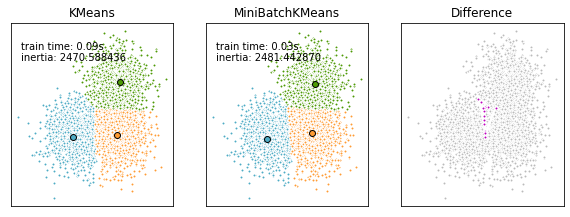

In [116]:
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn.datasets.samples_generator import make_blobs
# #############################################################################
# Generate sample data
np.random.seed(0)
batch_size = 45
centers = [[1, 1], [-1, -1], [1, -1]]
n_clusters = len(centers)
X, labels_true = make_blobs(n_samples=3000, centers=centers, cluster_std=0.7)
# #############################################################################
# Compute clustering with Means
k_means = KMeans(init='k-means++', n_clusters=3, n_init=10)
t0 = time.time()
k_means.fit(X)
t_batch = time.time() - t0
# #############################################################################
# Compute clustering with MiniBatchKMeans
mbk = MiniBatchKMeans(init='k-means++', n_clusters=3, batch_size=batch_size,
n_init=10, max_no_improvement=10, verbose=0)
t0 = time.time()

mbk.fit(X)
t_mini_batch = time.time() - t0
# #############################################################################
# Plot result
fig = plt.figure(figsize=(8, 3))
fig.subplots_adjust(left=0.02, right=0.98, bottom=0.05, top=0.9)
colors = ['#4EACC5', '#FF9C34', '#4E9A06']
# We want to have the same colors for the same cluster from the
# MiniBatchKMeans and the KMeans algorithm. Let's pair the cluster centers per
# closest one.
k_means_cluster_centers = np.sort(k_means.cluster_centers_, axis=0)
mbk_means_cluster_centers = np.sort(mbk.cluster_centers_, axis=0)
k_means_labels = pairwise_distances_argmin(X, k_means_cluster_centers)
mbk_means_labels = pairwise_distances_argmin(X, mbk_means_cluster_centers)
order = pairwise_distances_argmin(k_means_cluster_centers,
mbk_means_cluster_centers)
# KMeans
ax = fig.add_subplot(1, 3, 1)
for k, col in zip(range(n_clusters), colors):
    my_members = k_means_labels == k
    cluster_center = k_means_cluster_centers[k]
    ax.plot(X[my_members, 0], X[my_members, 1], 'w',
    markerfacecolor=col, marker='.')
    ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
    markeredgecolor='k', markersize=6)
ax.set_title('KMeans')
ax.set_xticks(())
ax.set_yticks(())
plt.text(-3.5, 1.8, 'train time: %.2fs\ninertia: %f' % (
    t_batch, k_means.inertia_))

# MiniBatchKMeans
ax = fig.add_subplot(1, 3, 2)
for k, col in zip(range(n_clusters), colors):
    my_members = mbk_means_labels == order[k]
    cluster_center = mbk_means_cluster_centers[order[k]]
    ax.plot(X[my_members, 0], X[my_members, 1], 'w',
    markerfacecolor=col, marker='.')
    ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
    markeredgecolor='k', markersize=6)
ax.set_title('MiniBatchKMeans')
ax.set_xticks(())
ax.set_yticks(())
plt.text(-3.5, 1.8, 'train time: %.2fs\ninertia: %f' %
    (t_mini_batch, mbk.inertia_))
# Initialise the different array to all False
different = (mbk_means_labels == 4)
ax = fig.add_subplot(1, 3, 3)
for k in range(n_clusters):
    different += ((k_means_labels == k) != (mbk_means_labels == order[k]))
identic = np.logical_not(different)
ax.plot(X[identic, 0], X[identic, 1], 'w',
markerfacecolor='#bbbbbb', marker='.')
ax.plot(X[different, 0], X[different, 1], 'w',
markerfacecolor='m', marker='.')
ax.set_title('Difference')
ax.set_xticks(())
ax.set_yticks(())
plt.show()